In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

import os
import numpy as np
import seaborn as sns

In [3]:
csv_dir = '/home/elliot/Documents/CVPR_2020/BFA_defense/BFA_defense/save/2019-11-13/cifar10_vgg11_quan_idx_3_eval'
# csv_dir = '/home/elliot/Documents/CVPR_2020/BFA_defense/BFA_defense/save/2019-11-13/cifar10_resnet20_quan_eval_idx1'
# csv_dir = '/home/elliot/Documents/CVPR_2020/BFA_defense/BFA_defense/save/2019-11-13/cifar10_resnet20_quan_idx_4'

csv_file_list = [file for file in os.listdir(
    csv_dir) if file.endswith('.csv')
]

# print(csv_file_list)

csv_dict = {}

# df = pd.DataFrame()
for file in csv_file_list:
    csv_dict[file] = pd.read_csv(os.path.join(csv_dir, file), index_col=False)

df = pd.concat([csv_dict[file] for file in csv_dict], ignore_index=True)

In [4]:
df

,module idx,bit-flip idx,module name,weight idx,weight before attack,weight after attack,validation accuracy,accuracy drop,trial seed
0,2,1,features.0,[2 0 2 0],-23.0,105.0,89.73,1.07,9264
1,2,2,features.0,[2 0 2 2],-7.0,121.0,86.04,3.69,9264
2,2,3,features.0,[2 0 0 2],-29.0,99.0,80.70,5.34,9264
3,2,4,features.0,[2 0 0 1],-63.0,65.0,74.69,6.01,9264
4,2,5,features.0,[2 0 2 1],-41.0,87.0,68.61,6.08,9264
...,...,...,...,...,...,...,...,...,...
278,5,25,features.3,[19 33 2 0],5.0,69.0,11.75,0.27,3569
279,2,26,features.0,[33 1 1 0],50.0,-78.0,11.50,0.25,3569
280,10,27,features.8,[ 95 165 2 1],-29.0,99.0,11.32,0.18,3569
281,5,28,features.3,[19 33 2 1],12.0,76.0,11.18,0.14,3569


# Analyze the attack

In [5]:
bfs = []
for idx in set(df['trial seed'].values.flatten()):
    bfs.append(df.loc[df['trial seed']==idx]['bit-flip idx'].max())
bfs = np.array(bfs)
print(
    'bit-flips for multiple trials {} \n \
mean: {} \n std: {}'.format(bfs, bfs.mean(), bfs.std())
)



bit-flips for multiple trials [ 65 122  29  37  30] 
 mean: 56.6 
 std: 35.21704132944731


In [6]:
from BFA_defense.visulization.torchsummary import summary
from BFA_defense.models import vanilla_resnet20, vgg11
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# m = vanilla_resnet20().to(device)
m = vgg11().to(device)
summary(m, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]          73,856
              ReLU-5          [-1, 128, 16, 16]               0
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 8, 8]         295,168
              ReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         590,080
             ReLU-10            [-1, 256, 8, 8]               0
        MaxPool2d-11            [-1, 256, 4, 4]               0
           Conv2d-12            [-1, 512, 4, 4]       1,180,160
             ReLU-13            [-1, 512, 4, 4]               0
           Conv2d-14            [-1, 51

# Plot for Observation-1

In [7]:
# plot style
sns.set(style="whitegrid")
sns.set(style="ticks")
# sns.despine()
sns.set_style({"font.sans-serif":"DejaVu Sans"})
sns.set_style({"grid.color":'0.9'})
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 1})

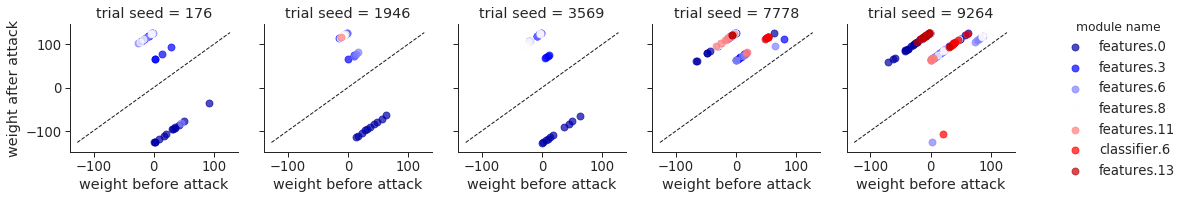

In [12]:
# f, ax = plt.subplots(figsize=(8,8))

g = sns.FacetGrid(df, col="trial seed", hue='module name',
                palette = 'seismic', margin_titles=True)
g.map(plt.scatter, "weight before attack", "weight after attack", alpha=.7, s=50)
g.add_legend()

for ax in g.axes.flat:
    ax.plot((-127, 127), (-127, 127), c=".1", ls="--")


# solution for color bar:
https://stackoverflow.com/questions/44641669/scatterplot-with-point-colors-representing-a-continuous-variable-in-seaborn-face

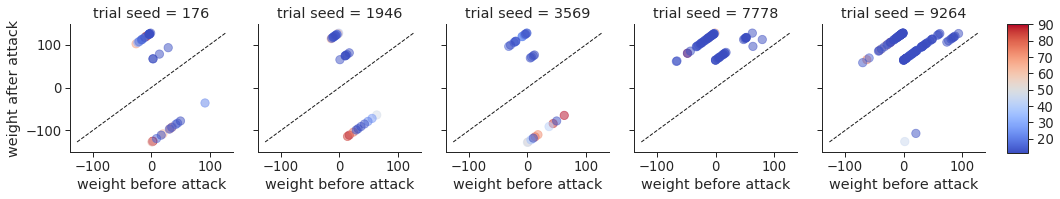

In [9]:
g = sns.FacetGrid(df, col="trial seed", palette = 'seismic')

def facet_scatter(x, y, c, **kwargs):
    """Draw scatterplot with point colors from a faceted DataFrame columns."""
    kwargs.pop("color")
    plt.scatter(x, y, c=c, **kwargs)

# print(df['accuracy drop'].max())
# vmin, vmax = 0, 30
# vmin, vmax = df['accuracy drop'].min(), df['accuracy drop'].max()
vmin, vmax = df['validation accuracy'].min(), df['validation accuracy'].max()

# cmap = sns.diverging_palette(240, 10, l=65, center="dark", as_cmap=True)
# cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True, center="light")
# cmap = sns.light_palette("red", as_cmap=True)
# cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
cmap = 'coolwarm'

g = g.map(facet_scatter,  "weight before attack", "weight after attack", 'validation accuracy',
          s=70, alpha=0.5, vmin=vmin, vmax=vmax, cmap=cmap)

# Make space for the colorbar
g.fig.subplots_adjust(right=.92)

# Define a new Axes where the colorbar will go
cax = g.fig.add_axes([.94, .25, .02, .6])

# Get a mappable object with the same colormap as the data
points = plt.scatter([], [], c=[], vmin=vmin, vmax=vmax, cmap=cmap)

# Draw the colorbar
g.fig.colorbar(points, cax=cax)

for ax in g.axes.flat:
    ax.plot((-127, 127), (-127, 127), c=".1", ls="--")

In [10]:
g.fig.savefig(os.path.join(csv_dir,'weight_change_vgg11_acc.pdf'), bbox_inches="tight", transparent=True)

# Observation 2
Get the histogram of the bits across different layers

/home/elliot/anaconda3/envs/pytorch041/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


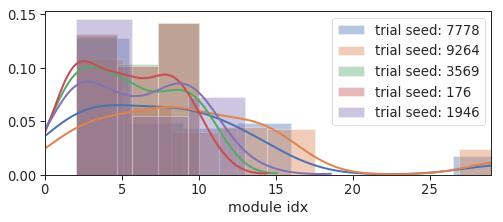

In [14]:
# from scipy import stats
# from scipy.stats import norm
f, ax = plt.subplots(figsize=(8,3))

plt.rcParams['lines.linewidth'] = 2

for idx in set(df['trial seed'].values.flatten()):
    sns.distplot(df.loc[df['trial seed']==idx]['module idx'], kde=True, label='trial seed: '+str(idx))
    plt.legend()
plt.xlim(0, 29)
f.savefig(os.path.join(csv_dir,'hist_bf_vs_layer_vgg11.pdf'), bbox_inches="tight", transparent=True)


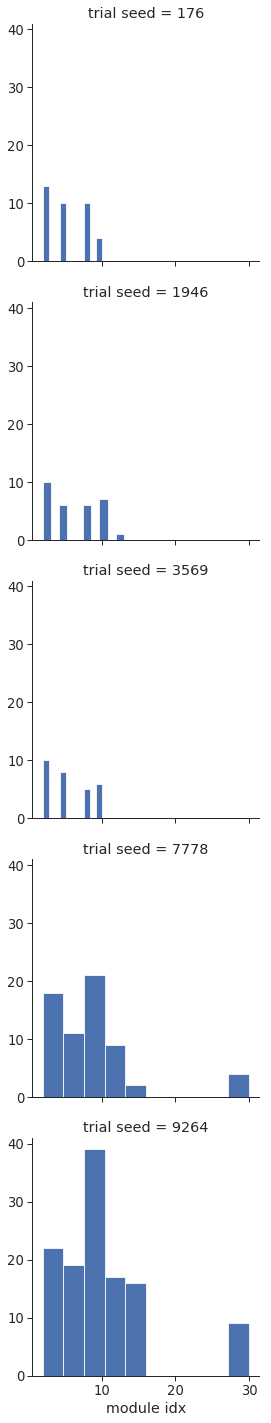

In [48]:
g = sns.FacetGrid(df, row='trial seed', height=2, aspect ratio)
g = g.map(plt.hist, 'module idx')